In [1]:
import pandas as pd
import numpy as np
import requests
import io

%load_ext autoreload
%autoreload 2

In [2]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"

data_response = requests.get(data_url)
test_response = requests.get(test_url)

In [3]:
df = (
   pd.read_csv(
      io.StringIO(data_response.content.decode('utf-8')),
      names=[
         'age',
         'workclass',
         'fnlwgt',
         'education',
         'education-num',
         'marital-status',
         'occupation',
         'relationship',
         'race',
         'sex',
         'capital-gain',
         'capital-loss',
         'hours-per-week',
         'native-country',
         'income',
      ],
      dtype={
         'age': np.int64,
         'workclass': 'category',
         'fnlwgt': np.int64,
         'education': 'category',
         'education-num': np.int64,
         'marital-status': 'category',
         'occupation': 'category',
         'relationship': 'category',
         'race': 'category',
         'sex': 'category',
         'capital-gain': np.int64,
         'capital-loss': np.int64,
         'hours-per-week': np.int64,
         'native-country': 'category',
         'income': 'category',
      },
      na_values='?',
      sep=', '
   )
   .dropna()
)
df.head()

/home/raeed/codebase/cmu-ml/cmu_intro_ml/.venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
def get_prior_probability(series, value):
    assert series.dtype.name == 'category'
    return sum(series==value)/len(series)

print('Prior probability of income <=50K: {0:.4g}'.format(get_prior_probability(df['income'], '<=50K')))
print('Prior probability of income >50K: {0:.4g}'.format(get_prior_probability(df['income'], '>50K')))


Prior probability of income <=50K: 0.7511
Prior probability of income >50K: 0.2489


In [5]:
def get_naive_bayes_alpha(cat_series, cat_val, class_series, class_val):
    assert cat_series.dtype.name == 'category'
    assert class_series.dtype.name == 'category'
    assert len(cat_series) == len(class_series)

    sub_series = cat_series[class_series==class_val]
    return get_prior_probability(sub_series, cat_val)

# test on given solution
workclass_alpha_below = {key: get_naive_bayes_alpha(df['workclass'], key, df['income'], '<=50K') for key in ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked']}
workclass_alpha_above = {key: get_naive_bayes_alpha(df['workclass'], key, df['income'], '>50K') for key in ['Private', 'Self-emp-not-inc', 'Self-emp-inc', 'Federal-gov', 'Local-gov', 'State-gov', 'Without-pay', 'Never-worked']}
print(workclass_alpha_above)
print(workclass_alpha_below)

{'Private': 0.6494405966968567, 'Self-emp-not-inc': 0.09509856153436334, 'Self-emp-inc': 0.07991475759190197, 'Federal-gov': 0.048614810868407035, 'Local-gov': 0.0811134789557805, 'State-gov': 0.04581779435269046, 'Without-pay': 0.0, 'Never-worked': 0.0}
{'Private': 0.768517701068244, 'Self-emp-not-inc': 0.07879403195903593, 'Self-emp-inc': 0.020923457226096936, 'Federal-gov': 0.025514257967687824, 'Local-gov': 0.06435949501191843, 'State-gov': 0.041273064359495015, 'Without-pay': 0.0006179924075218504, 'Never-worked': 0.0}


In [6]:
def get_naive_bayes_gauss_params(cont_series, class_series, class_val):
    assert cont_series.dtype.name != 'category'
    assert class_series.dtype.name == 'category'
    assert len(cont_series) == len(class_series)

    sub_series = cont_series[class_series==class_val]
    return {'mean': sub_series.mean(), 'variance': sub_series.var(ddof=0)}

# test on given solution
age_params_below = get_naive_bayes_gauss_params(df['age'], df['income'], '<=50K')
age_params_above = get_naive_bayes_gauss_params(df['age'], df['income'], '>50K')
print(age_params_above)
print(age_params_below)

{'mean': 43.95911028236548, 'variance': 105.4513115152752}
{'mean': 36.60806038668668, 'variance': 181.28829205320872}


In [7]:
def get_generic_nb_params(pred_series, class_series, class_val):
    assert class_series.dtype.name == 'category'
    assert len(pred_series) == len(class_series)

    if pred_series.dtype.name == 'category':
        return {key: get_naive_bayes_alpha(pred_series, key, class_series, class_val) for key in pred_series.cat.categories}
    else:
        return get_naive_bayes_gauss_params(pred_series, class_series, class_val)

In [8]:
for label in ['<=50K', '>50K']:
    print(label)
    for col in ['education-num','marital-status','race','capital-gain']:
        print(f"{col} ({label}): {get_generic_nb_params(df[col],df['income'],label)}")

<=50K
education-num (<=50K): {'mean': 9.629116270857244, 'variance': 5.82518914574656}
marital-status (<=50K): {'Divorced': 0.16606338836408582, 'Married-AF-spouse': 0.00048556546305288247, 'Married-civ-spouse': 0.3383949854330361, 'Married-spouse-absent': 0.01496424472499338, 'Never-married': 0.4085812660015891, 'Separated': 0.03853624084046967, 'Widowed': 0.03297430917277302}
race (<=50K): {'Amer-Indian-Eskimo': 0.011123863335393308, 'Asian-Pac-Islander': 0.028560077690474087, 'Black': 0.10819281363114681, 'Other': 0.009269886112827757, 'White': 0.842853359230158}
capital-gain (<=50K): {'mean': 148.8938377328507, 'variance': 876791.7958717996}
>50K
education-num (>50K): {'mean': 11.606419818859882, 'variance': 5.608680149804337}
marital-status (>50K): {'Divorced': 0.06020245071923282, 'Married-AF-spouse': 0.0013319126265316996, 'Married-civ-spouse': 0.8522908897176346, 'Married-spouse-absent': 0.004128929142248269, 'Never-married': 0.06259989344698988, 'Separated': 0.0087906233351092

In [9]:
def fit_nb_classifier(df):
    '''
    Fit parameters of naive bayes classifier

    Args:
        df: dataframe with columns 'pred_col' and 'class_col'

    Returns:
        dict of parameters
    '''

    nb_prior_params = {
        label: get_prior_probability(df['income'],label)
        for label in ['<=50K', '>50K']
    }
    nb_likelihood_params = {
        label: {
            col: get_generic_nb_params(df[col],df['income'],label)
            for col in df.columns if col is not 'income'
        }
        for label in ['<=50K', '>50K']
    }

    return nb_prior_params,nb_likelihood_params

nb_prior_params,nb_likelihood_params = fit_nb_classifier(df)
print(nb_prior_params)
print(nb_likelihood_params)

{'<=50K': 0.7510775147536636, '>50K': 0.24892248524633645}
{'<=50K': {'age': {'mean': 36.60806038668668, 'variance': 181.28829205320872}, 'workclass': {'Federal-gov': 0.025514257967687824, 'Local-gov': 0.06435949501191843, 'Never-worked': 0.0, 'Private': 0.768517701068244, 'Self-emp-inc': 0.020923457226096936, 'Self-emp-not-inc': 0.07879403195903593, 'State-gov': 0.041273064359495015, 'Without-pay': 0.0006179924075218504}, 'fnlwgt': {'mean': 190338.64672905448, 'variance': 11356949805.69214}, 'education': {'10th': 0.03359230158029487, '11th': 0.043656749359936436, '12th': 0.015361525558400282, '1st-4th': 0.006400635649333451, '5th-6th': 0.012183278891145052, '7th-8th': 0.023042288337600424, '9th': 0.018981195373885408, 'Assoc-acdm': 0.03319502074688797, 'Assoc-voc': 0.04250904917453871, 'Bachelors': 0.12880727465348282, 'Doctorate': 0.004193519908183985, 'HS-grad': 0.3629822547894412, 'Masters': 0.03129690120949943, 'Preschool': 0.0019864041670345192, 'Prof-school': 0.00600335481592654

In [10]:
test_df = (
   pd.read_csv(
      io.StringIO(test_response.content.decode('utf-8')),
       names=[
          'age',
          'workclass',
          'fnlwgt',
          'education',
          'education-num',
          'marital-status',
          'occupation',
          'relationship',
          'race',
          'sex',
          'capital-gain',
          'capital-loss',
          'hours-per-week',
          'native-country',
          'income',
       ],
       dtype={
          'age': np.int64,
          'workclass': 'category',
          'fnlwgt': np.int64,
          'education': 'category',
          'education-num': np.int64,
          'marital-status': 'category',
          'occupation': 'category',
          'relationship': 'category',
          'race': 'category',
          'sex': 'category',
          'capital-gain': np.int64,
          'capital-loss': np.int64,
          'hours-per-week': np.int64,
          'native-country': 'category',
          'income': 'category',
       },
       na_values='?',
       sep=', ',
       skiprows=1,
   )
   .dropna()
)
test_df['income'].cat.rename_categories({'<=50K.': '<=50K', '>50K.': '>50K'}, inplace=True)
test_df.head()

/home/raeed/codebase/cmu-ml/cmu_intro_ml/.venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/home/raeed/codebase/cmu-ml/cmu_intro_ml/.venv/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2631: FutureWarning: The `inplace` parameter in pandas.Categorical.rename_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  res = method(*args, **kwargs)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [11]:
def calc_log_likelihood(col, likelihood_params):
    '''
    Calculate the log likelihood of a column given the likelihood parameters.

    Args:
        col: A pandas series of the column to calculate the log likelihood of.
        likelihood_params: A dictionary of the likelihood parameters.

    Returns:
        A pandas series of the log likelihood of the column.
    '''
    if col.dtype.name == 'category':
        log_likelihood_params = {key: np.log(val) if val!=0 else -np.inf for key, val in likelihood_params.items()}
        return col.map(log_likelihood_params).astype(np.float32).fillna(-np.inf)
    else:
        # vectorized
        eps = 1e-9
        mean = likelihood_params['mean']
        var = likelihood_params['variance']+eps
        return -0.5*np.log(2*np.pi*var) - 0.5*((col-mean)**2/var)

def calc_log_posterior(test_df,labels,nb_prior_params,nb_likelihood_params):
    '''
    Calculates the log posteriors for each row of the data given an assumed class label
    and naive bayes parameters (prior and likelihood)

    Args:
        test_df: A pandas dataframe of the test data.
        labels: A pandas series of the assumed class labels or a single assumed label (string)
        nb_prior_params: A dictionary of the naive bayes prior parameters.
        nb_likelihood_params: A dictionary of the naive bayes likelihood parameters.

    Returns:
        A pandas series of the log posteriors for each row, assuming the given class labels
    '''

    if type(labels) is str:
        labels = pd.Series([labels]*len(test_df),index=test_df.index)

    log_prior_params = {key: np.log(val) for key, val in nb_prior_params.items()}
    log_prior = labels.map(log_prior_params).astype(np.float32)

    log_likelihood = pd.concat([
        calc_log_likelihood(test_df[colname], nb_likelihood_params[label][colname])
        for colname in test_df if colname in nb_likelihood_params[label]
    ],axis=1).sum(axis=1)

    return log_prior + log_likelihood

# for line,row in test_df.head(10).iterrows():
#     print(f"{line}: {calc_log_posterior(row,row['income'],nb_prior_params,nb_likelihood_params)}")

calc_log_posterior(test_df.head(10),test_df['income'].head(10),nb_prior_params,nb_likelihood_params)


0    -62.251311
1    -47.175725
2    -52.699990
3    -49.735549
5    -57.927771
7    -51.370071
8    -57.379948
9    -59.224411
10   -49.036513
11   -47.359949
dtype: float64

In [12]:
def nb_classify(test_df,nb_prior_params,nb_likelihood_params):
    '''
    Classifies the test data using naive bayes.

    Args:
        test_df: A pandas dataframe of the test data.
        nb_prior_params: A dictionary of the naive bayes prior parameters.
        nb_likelihood_params: A dictionary of the naive bayes likelihood parameters.

    Returns:
        A pandas series of the predicted class labels.
    '''
    log_posteriors = pd.DataFrame({
        label: calc_log_posterior(test_df,label,nb_prior_params,nb_likelihood_params)
        for label in ['<=50K', '>50K']
    })

    class_labels = log_posteriors.idxmax(axis=1).astype('category')
    return class_labels

def score_classifier(test_df,nb_prior_params,nb_likelihood_params):
    '''
    Scores the classifier using the test data.

    Args:
        test_df: A pandas dataframe of the test data.
        class_labels: A pandas series of the predicted class labels.

    Returns:
        The accuracy of the classifier.
    '''
    class_labels = nb_classify(test_df,nb_prior_params,nb_likelihood_params)
    return (class_labels.astype(str) == test_df['income'].astype(str)).mean()

print(f"Train accuracy: {score_classifier(df,nb_prior_params,nb_likelihood_params)}")
print(f"Test accuracy: {score_classifier(test_df,nb_prior_params,nb_likelihood_params)}")

Train accuracy: 0.7510775147536636
Test accuracy: 0.7543160690571049


In [13]:
def load_n_training_samples(n_samples):
    df = (
       pd.read_csv(
           '../data/adult.data',
           names=[
              'age',
              'workclass',
              'fnlwgt',
              'education',
              'education-num',
              'marital-status',
              'occupation',
              'relationship',
              'race',
              'sex',
              'capital-gain',
              'capital-loss',
              'hours-per-week',
              'native-country',
              'income',
           ],
           dtype={
              'age': np.int64,
              'workclass': 'category',
              'fnlwgt': np.int64,
              'education': 'category',
              'education-num': np.int64,
              'marital-status': 'category',
              'occupation': 'category',
              'relationship': 'category',
              'race': 'category',
              'sex': 'category',
              'capital-gain': np.int64,
              'capital-loss': np.int64,
              'hours-per-week': np.int64,
              'native-country': 'category',
              'income': 'category',
           },
           na_values='?',
           sep=', '
       )
       .head(n_samples)
       .dropna()
    )

    return df

def fit_score_classifier(df,test_df):
    '''
    Fits the classifier to the training data and scores it using the test data.

    Args:
        df: A pandas dataframe of the training data.
        test_df: A pandas dataframe of the test data.

    Returns:
        training accuracy
        testing accuracy
    '''
    nb_prior_params,nb_likelihood_params = fit_nb_classifier(df)
    train_acc = score_classifier(df,nb_prior_params,nb_likelihood_params)
    test_acc = score_classifier(test_df,nb_prior_params,nb_likelihood_params)
    return train_acc,test_acc

scores = pd.DataFrame([
    (n,)+fit_score_classifier(load_n_training_samples(n),test_df)
    for n in [2**i for i in range(5,14)]
],columns=['Number of Samples','Train','Test'])


/home/raeed/codebase/cmu-ml/cmu_intro_ml/.venv/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


<AxesSubplot:xlabel='Number of Samples', ylabel='Accuracy'>

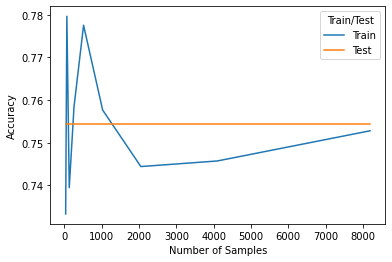

In [14]:
import seaborn as sns
scores = scores.melt(id_vars=['Number of Samples'],value_vars=['Train','Test'],value_name='Accuracy',var_name='Train/Test')
sns.lineplot(x='Number of Samples',y='Accuracy',hue='Train/Test',data=scores)